<a href="https://colab.research.google.com/github/derekriceX/Bayesian-Analysis/blob/main/Bike_rent_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
#from scipy import stats
from scipy.stats import beta, norm

In [21]:
# !pip install ucimlrepo


In [22]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets

In [23]:
X.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [24]:
y.head()

,cnt
0,16
1,40
2,32
3,13
4,1


In [25]:
# (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39

X['Temp_C'] = X['atemp']*(39-8)+8

X.head()

/tmp/ipython-input-856218801.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Temp_C'] = X['atemp']*(39-8)+8


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,Temp_C
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16.9249
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,16.4537
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,16.4537
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,16.9249
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,16.9249


In [26]:
print(X.shape)
print(y.shape)

(17379, 14)
(17379, 1)


In [27]:
X.head(0)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,Temp_C


In [28]:
y.head(0)

,cnt


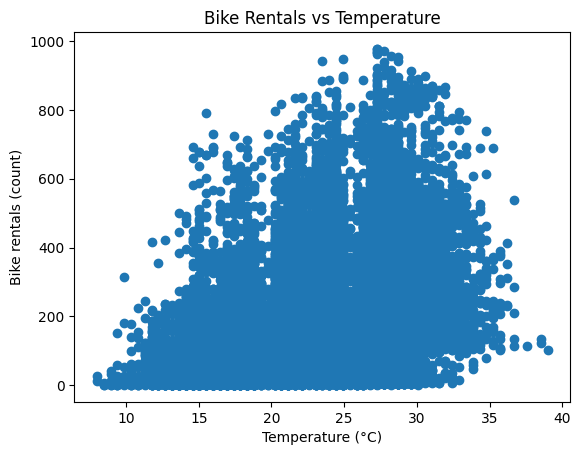

In [29]:
# Align X and y to ensure matching indexes
X_aligned, y_aligned = X.align(y, join='inner', axis=0)

# Now plot
plt.figure()
plt.scatter(X_aligned['Temp_C'], y_aligned['cnt'])
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike rentals (count)")
plt.title("Bike Rentals vs Temperature")
plt.show()


In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
# features (temp) needs to be 2D: shampe (n_samples, 1)
X = X[['Temp_C']] # keeps it as a DataFrame (2D)
y = y['cnt'] # target values

# combine X and y into a single dataframe - address n/a in data
df = pd.concat([X,y],axis=1)

df_clean = df.dropna()

In [32]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [33]:
y_pred = model.predict(X)

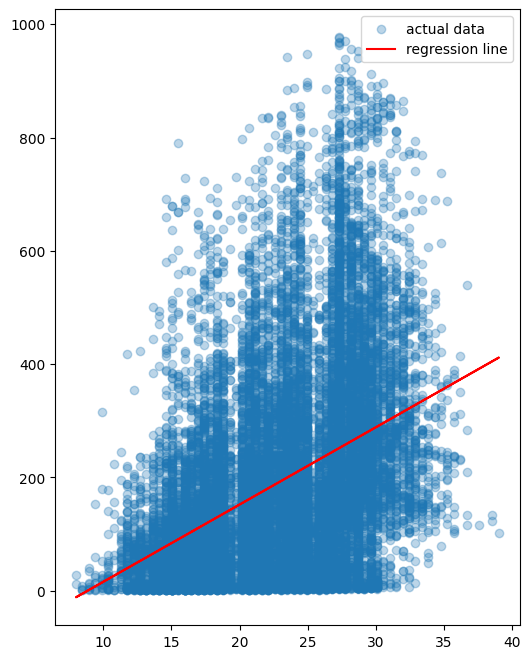

In [34]:
plt.figure(figsize=(6,8))
plt.scatter(X,y,alpha=0.3, label='actual data')
plt.plot(X,y_pred, color='red', label ='regression line')
plt.legend()
plt.show()

In [35]:
# create some simulated data

np.random.seed(42)
N = 100
x = np.linspace(10,35,N)
true_alpha = 100 # intercept
true_beta = 20 # slope
true_sigma = 30 # error

y = true_alpha + true_beta*x + np.random.normal(0,true_sigma,N)

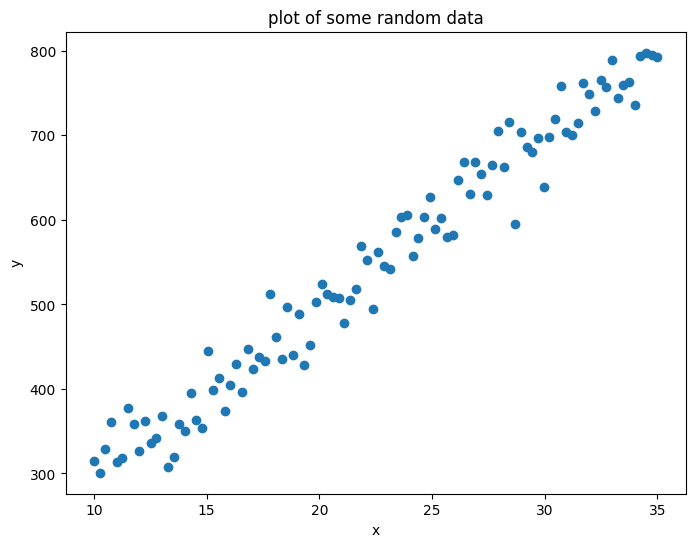

In [36]:
plt.figure(figsize=(8,6))
plt.plot(x,y,'o')
plt.title('plot of some random data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [43]:
x = df_clean['Temp_C'].values
y = df_clean['cnt'].values

# Standardize x and y
x_mean, x_std = x.mean(), x.std()
x_stdzd = (x - x_mean) / x_std

y_mean, y_std = y.mean(), y.std()
y_stdzd = (y - y_mean) / y_std

In [44]:
# step 3 - define the log-prior, log-likelihood, and log posterior

def log_prior(alpha, beta, sigma):
  if sigma <= 0:
    return -np.inf # invalid
  lp_alpha = norm.logpdf(alpha, loc=0, scale=100)
  lp_beta = norm.logpdf(beta, loc=0, scale=10)

  # half-Cauchy ~ Cauchy (0, 10) restricted to sigma > 0
  lp_sigma = np.log(2/np.pi *10*(1 + (sigma/10)**2))

  return lp_alpha + lp_beta + lp_sigma

def log_likelihood(alpha, beta, sigma, x, y):
  mu = alpha + beta * x
  return np.sum(norm.logpdf(y, loc = mu, scale = sigma))

def log_posterior(alpha, beta, sigma, x, y):
  return log_prior(alpha, beta, sigma) + log_likelihood(alpha, beta, sigma, x, y)

In [45]:
def metropolis_hastings (x, y, n_samples = 5000):
  samples = []
  alpha, beta, sigma = 0.0, 0.0, 1.0 # initial values

  for _ in range(n_samples):
    # propose new values
    alpha_p = np.random.normal(alpha, 0.5)
    beta_p = np.random.normal(beta, 0.5)
    sigma_p = np.abs(np.random.normal(sigma,0.1)) # positive

    # compute log acceptance ration
    logp_current = log_posterior (alpha, beta, sigma, x, y)
    logp_proposed = log_posterior (alpha_p, beta_p, sigma_p, x, y)

    accept_ratio = np.exp(logp_proposed - logp_current)

    # accept or reject
    if np.random.rand() < accept_ratio:
      alpha, beta, sigma = alpha_p, beta_p, sigma_p
    samples.append([alpha, beta, sigma])

  return np.array(samples)

In [46]:
samples = metropolis_hastings(x_stdzd, y_stdzd, n_samples=5000)

alpha_samples, beta_samples, sigma_samples = samples.T

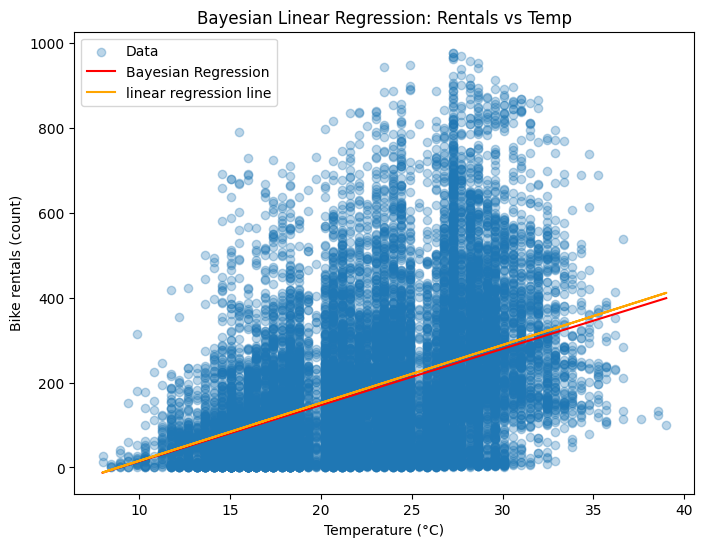

In [50]:

# Use posterior mean
alpha_post = alpha_samples[-1000:].mean()
beta_post  = beta_samples[-1000:].mean()

x_plot = np.linspace(x_stdzd.min(), x_stdzd.max(), 100)
y_plot = alpha_post + beta_post * x_plot

# Convert back to original scale
x_plot_orig = x_plot * x_std + x_mean
y_plot_orig = y_plot * y_std + y_mean

# Scatter and regression line
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, label='Data')
plt.plot(x_plot_orig, y_plot_orig, color='red', label='Bayesian Regression')
plt.plot(X,y_pred, color='orange', label ='linear regression line')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bike rentals (count)")
plt.title("Bayesian Linear Regression: Rentals vs Temp")
plt.legend()
plt.show()
